In [1]:
%matplotlib inline


import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os

tf.reset_default_graph()

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using the same image data cleaning I used for the CNN example.

In [2]:
newsize = 360  #The new dimensions of the flowers, will be applied throughout the autoencoder. 

In [3]:
#Making my daisy set in here

X_daisies = []
y_daisies = []
for file in os.listdir('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/daisy'):
    if file.endswith(".jpg"):
        img = cv2.imread('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/daisy/' + file)
        X_daisies.append((img))
        y_daisies.append([np.float64(1),np.float64(0),np.float64(0),np.float64(0),np.float64(0)])

        
        
#Now for dandelions
X_dandelions = []
y_dandelions = []
for file in os.listdir('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/dandelion'):
    #print(filename)
    if file.endswith(".jpg"):
        img = cv2.imread('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/dandelion/' + file)
        X_dandelions.append((img))
        y_dandelions.append([np.float64(0),np.float64(1),np.float64(0),np.float64(0),np.float64(0)])

#Now for roses
X_roses = []
y_roses = []
for file in os.listdir('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/rose'):
    #print(filename)
    if file.endswith(".jpg"):
        img = cv2.imread('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/rose/' + file)
        X_roses.append((img))
        y_roses.append([np.float64(0),np.float64(0),np.float64(1),np.float64(0),np.float64(0)])

#Now for sunflowers
X_sunflowers = []
y_sunflowers = []
for file in os.listdir('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/sunflower'):
    #print(filename)
    if file.endswith(".jpg"):
        img = cv2.imread('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/sunflower/' + file)
        X_sunflowers.append((img))
        y_sunflowers.append([np.float64(0),np.float64(0),np.float64(0),np.float64(1),np.float64(0)])

#Last but not least, tulips
X_tulips = []
y_tulips = []
for file in os.listdir('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/tulip'):
    #print(filename)
    if file.endswith(".jpg"):
        img = cv2.imread('/Users/noahkasmanoff/MachLearn/Phys476/hw4/flowers/tulip/' + file)
        X_tulips.append((img))
        y_tulips.append([np.float64(0),np.float64(0),np.float64(0),np.float64(0),np.float64(1)])
        
        
#Merging all at once. 4236 flowers in all. 

X_args = (X_daisies,X_dandelions,X_roses,X_sunflowers,X_tulips)
y_args = (y_daisies,y_dandelions,y_roses,y_sunflowers,y_tulips)
X_flowers = np.concatenate(X_args)
y_flowers = np.concatenate(y_args)


# Resize images
def resize_with_pad(img, img_size):
    height, width, _ = img.shape
    ratio = img_size / max(height, width)
   # print(ratio)
    if ratio < 1:
        img = cv2.resize(img, (int(ratio * width), int(ratio * height)))
    padding = ((img_size - img.shape[0], 0), (img_size - img.shape[1],0), (0,0))

    return np.pad(img, padding, 'constant')

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

for i in range(0,len(X_flowers)):
    
    X_flowers[i] = resize_with_pad(X_flowers[i], newsize)
    X_flowers[i] = rgb2gray(X_flowers[i])
   # X_flowers[i] = np.array(X_flowers[i]).reshape(1, 360,360,3) useless!
    #Extra line here reshapes to accept batch size as a dimension of accepted pics at once
    
#In order for this to be read in tensorflow, all these values need to be float32's. That is done below. 

for j in range(0,len(X_flowers)):
    X_flowers[j] = (X_flowers[j]).flatten()/255
    X_flowers[j] = np.array(X_flowers[j],dtype='float32')
    #Float 32 conversion

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_flowers, y_flowers, test_size=0.33, random_state=42)

In [5]:
# A function used for the CNN. 
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [9]:
# Training Parameters
learning_rate = .001
num_steps = 3000
batch_size = 256

display_step = 100
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = newsize*newsize # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [10]:

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [11]:

# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = next_batch(batch_size,X_train,y_train)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.371385
Step 10: Minibatch Loss: 0.374370
Step 20: Minibatch Loss: 0.374562
Step 30: Minibatch Loss: 0.370774


Original Images


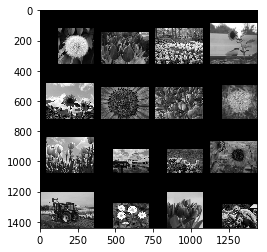

Reconstructed Images


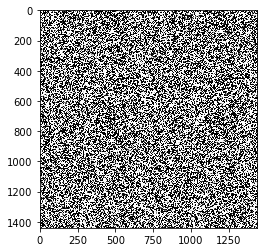

In [13]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((newsize * n, newsize * n))
canvas_recon = np.empty((newsize * n, newsize * n))
for i in range(n):
    # MNIST test set
    batch_x, _ = next_batch(batch_size,X_train,y_train)
    # Encode and decode the digit image
    g = sess.run(decoder_op, feed_dict={X: batch_x})
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * newsize:(i + 1) * newsize, j * newsize:(j + 1) * newsize] = batch_x[j].reshape([newsize, newsize])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * newsize:(i + 1) * newsize, j * newsize:(j + 1) * newsize] = g[j].reshape([newsize, newsize])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()